## Visualizing  Spacy + Georesolver  - By Years

### Loading the necessary libraries

In [69]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [70]:
def read_query_results(filename):
    with open('./results_ChapterBooks/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [71]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            #print("k is %s" %k)
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    c_locs=[]
                    c_locs.append(locs[t]["lat"])
                    c_locs.append(locs[t]["long"])
                    c_locs.append(t.split("-")[0])
                    c_locs.append(page)
                    c_locs.append(year)
                    data.append(c_locs)
                    l_ind = l_ind + 1
                
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [72]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [73]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            #print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [74]:
def plot_bar_places_by_years(df_group_places_years,plot_type="resolved"):
    num_subplots=len(df_group_places_years.keys())
    fig, axs = plt.subplots(num_subplots,1, squeeze=False)
    plt.subplots_adjust(hspace = 0.8, top=0.95)
    fig.set_size_inches(25, 45)
    i=0
    if plot_type == "resolved":
        fig.suptitle('15 Places most mentioned using Spacy and the Georesolver', fontsize = 25)
    else:
        fig.suptitle('15 Places most mentioned but not resolved using Spacy and the Georesolver ', fontsize = 25)
    for y in sorted(df_group_places_years.keys()):
        df_group_places = df_group_places_years[y]
        index = np.arange(len(df_group_places['Place']))

        if plot_type == "resolved":
            axs[i,0].bar(index, df_group_places['count'], color='green')
            axs[i,0].set_title('Year %s' %y, fontsize=25)
        else: 
            axs[i,0].bar(index, df_group_places['count'], color='darkgreen')
            axs[i,0].set_title('Year %s' %y, fontsize=25)
        axs[i,0].set_xticks(index) 
        axs[i,0].set_xticklabels(list(df_group_places['Place']), rotation=25, fontsize=22)
        fig.canvas.draw()
        axs[i,0].set_yticklabels(axs[i,0].get_yticklabels(), fontsize=25)  
        axs[i,0].set_ylabel('Frequency', fontsize=25) 
        i=i + 1

In [75]:
# Plot lines of different places
def cumulative_plot(df, list_places, list_years):
    fig = plt.figure(figsize=(12, 6))
    line_weight = 3
    alpha = .5
    tt=df_group_places_years_final.reset_index()
    years=set()
    for pl in list_places:
        freq_term={}
        for i in sorted(list_years):
            try:
                freq_term[i]= list(tt.loc[(tt['Place']==pl) & (tt['level_0']==i) ]["count"])[0]
            except:
                freq_term[i] = 0
        plt.plot(*zip(*sorted(freq_term.items())), lw=line_weight, alpha=alpha, label=pl, marker='d') 
    
    for i in sorted(list_years):
        years.add(i)
    plt.xticks(sorted(list(years)), rotation=50, fontsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.title('Yearly cumulative frequencies using\n'+ 'Spacy and the Georesolver',  fontsize=25)
    plt.legend(loc='upper left')
    plt.ylabel('Frequency of Places', fontsize=20) 
    plt.xlabel("Years", fontsize=20) 
    plt.show()

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in chapter-book.txt, which each corresponds to a book of the "ChapterBooks"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 



### Reading the file and creating the first dataframe

In [42]:
results=read_query_results('georesolution-chapbooks-sample')

/anaconda3/envs/mypython3/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
df_total= geresolution_dataframe(results)

year 1826
year 1835
year 1836
year 1838


In [44]:
df_total.head(15)

,Latitude,Longitude,Place,Page,Year
0,57.15581542635205,-2.189135946789114,ABERDEEN,Page1,1826
1,51.60206321410553,-2.730540808893425,Mount,Page4,1826
2,51.21760034129579,-2.151719256134133,Sack,Page4,1826
3,52.4585767008825,-0.5517685164556149,bield,Page4,1826
4,55.33475637101743,-3.986264167260694,glen,Page5,1826
5,57.58115491884349,-4.958935288234323,highland,Page5,1826
6,55.27267211291878,-4.118628093624643,hill,Page5,1826
7,56.0000000,-4.0000000,Scotland,Page6,1826
8,56.0000000,-4.0000000,Scotland,Page6,1826
9,56.0000000,-4.0000000,Scotland,Page6,1826


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [45]:
df_total[["Place"]].count()

Place    85
dtype: int64

### Explorations with georesolved places

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [46]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')

In [47]:
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')

In [48]:
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

In [49]:
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

In [50]:
df_total.loc[df_total['Latitude'] == ''].count()

Latitude     8
Longitude    8
Place        8
Page         8
Year         8
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [51]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     77
Longitude    77
Place        77
Page         77
Year         77
dtype: int64

**Important: New dataframe- df_resolved- without the rows has been resolved!!**

In [52]:
df_resolved = df_total[df_total['Latitude'] != '']

In [53]:
df_resolved.count()

Latitude     77
Longitude    77
Place        77
Page         77
Year         77
dtype: int64

**Places names - forcing all to lower case, and later capitalize them**

In [54]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [55]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#displaying the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,57.15581542635205,-2.189135946789114,Aberdeen,Page1,1826
1,51.60206321410553,-2.730540808893425,Mount,Page4,1826
2,51.21760034129579,-2.151719256134133,Sack,Page4,1826
3,52.4585767008825,-0.5517685164556149,Bield,Page4,1826
4,55.33475637101743,-3.986264167260694,Glen,Page5,1826
5,57.58115491884349,-4.958935288234323,Highland,Page5,1826
6,55.27267211291878,-4.118628093624643,Hill,Page5,1826
7,56.0000000,-4.0000000,Scotland,Page6,1826
8,56.0000000,-4.0000000,Scotland,Page6,1826
9,56.0000000,-4.0000000,Scotland,Page6,1826


**Important: Calculating the number of georesolved places by year**

Here is when I realised that we had empty geolocations for some editions. 

In [56]:
df_capitalized.groupby("Year")["Place"].count()

Year
1826    24
1835     3
1836    43
1838     7
Name: Place, dtype: int64

### Visualizing the 15 places more mentioned (and resolved) per year

In [57]:
mpl.rcParams['figure.dpi']=300
years_list = df_capitalized['Year'].unique()
filter_list=[]
df_group_places_years={}
for y in years_list:
    df_filter_year=df_capitalized.loc[df_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
    filter_list=['Ii', 'United presbyterian']
    #place_label, place_freq = label_freq_places(df_filter_year, df_max_geolocations, filter_list)
    
    df_max_filter= df_max_geolocations[~df_max_geolocations['Place'].isin(filter_list)]
    place_label= df_max_filter['Place'].tolist()[0:15]
    place_freq= df_max_filter['count'].tolist()[0:15]
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    df_group_places_years[y]=df_group_places

In [61]:
plot_bar_places_by_years(df_group_places_years,plot_type="resolved")

### Cumulative Yearly Plot 

First we have to create a new concatenated dataframe with all the information per year - Years as the index 

In [63]:
df_group_places_years_final = pd.concat(df_group_places_years)

In [64]:
df_group_places_years_final.head(15)

Place  count
1826 10  Scotland     13
     0   Aberdeen      1
     1      Bield      1
     2    Britain      1
     3       Fife      1
     4       Glen      1
     5   Highland      1
     6       Hill      1
     7      Isles      1
     8      Mount      1
     9       Sack      1
     11     Spain      1
1835 0       Kent      1
     1         Ny      1
     2     Street      1

Just an example how to explore the number of times that Edinburgh has been georesolved over the years

In [66]:
df_group_places_years_final.loc[df_group_places_years_final['Place']=='Aberdeen']


,,Place,count
1826,0,Aberdeen,1


In [67]:
df_group_places_years_final.Place.unique()

array(['Scotland', 'Aberdeen', 'Bield', 'Britain', 'Fife', 'Glen',
       'Highland', 'Hill', 'Isles', 'Mount', 'Sack', 'Spain', 'Kent',
       'Ny', 'Street', 'Earth', 'Ayrshire', 'Borestone', 'The',
       'Waterside', 'Ireland', 'Loanhead', 'Park', 'Providence',
       'Renfrew', 'Rome', 'United', 'Ward', 'West', 'Almond', 'Craggan',
       'Lawers', 'Scotia'], dtype=object)

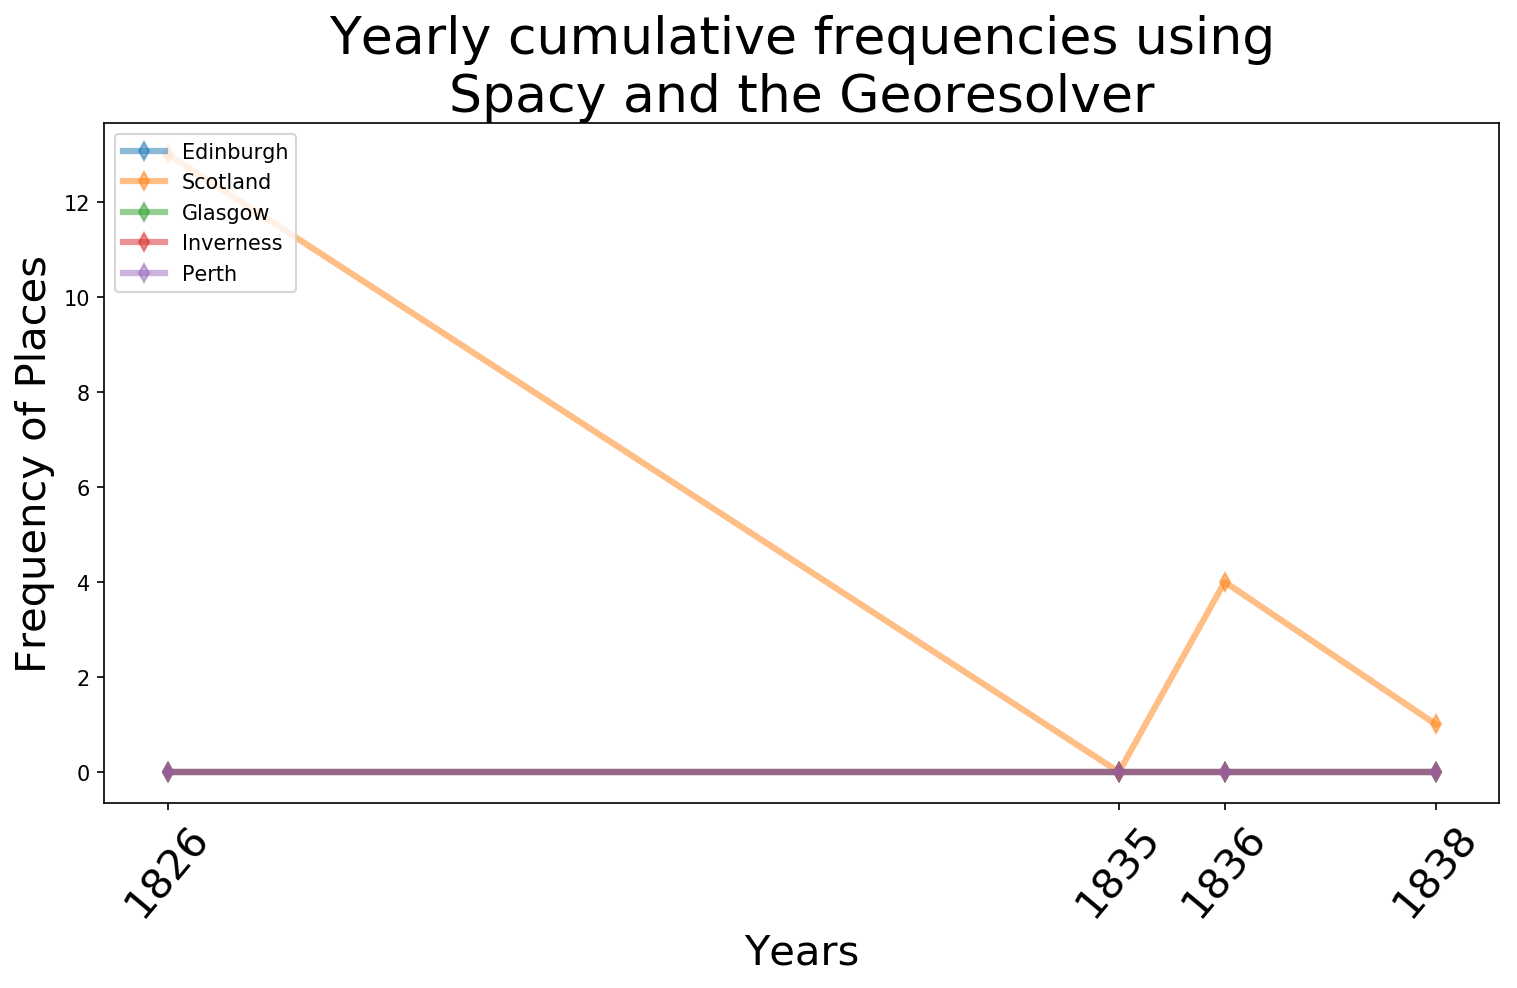

In [68]:
#df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']
mpl.rcParams['figure.dpi']=150
list_places=["Edinburgh", "Scotland", "Glasgow", "Inverness", "Perth"]
cumulative_plot(df_group_places_years, list_places, sorted(years_list))